# Lyft's Bay Wheels Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
%matplotlib inline

## Dataset Overview

This dataset originally consisted of more than 4.7 million bike trips and spanned over a 2-year time frame.  Main attributes included distance, duration, time of usage (*day of week*, *time period*, *hour*), user type (*subscriber*/*user*) and Bike Share for All* enrollment.  500,000 data points were removed from the analysis due to missing or inaccurate information.  

*The Bike Share for All program is offered to Bay Area residents on a limited income.

In [3]:
df = pd.read_csv('lyft_baywheels.csv', dtype={'bike_share_for_all_trip': object, 'rental_access_method': object})

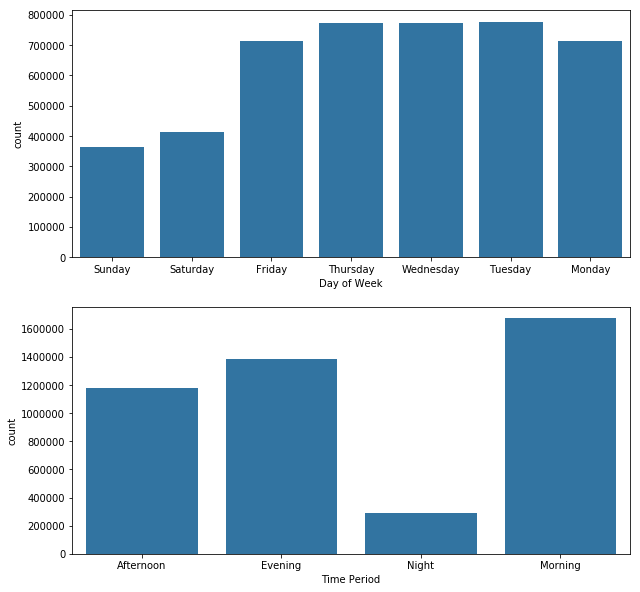

In [5]:
fig, ax = plt.subplots(2,1, figsize=[10,10])
color = sb.color_palette()[0]
sb.countplot(data=df, x='start_week', ax=ax[0], color= color)
sb.countplot(data=df, x='period', ax=ax[1], color= color)
ax[0].set_xlabel('Day of Week')
ax[1].set_xlabel('Time Period');

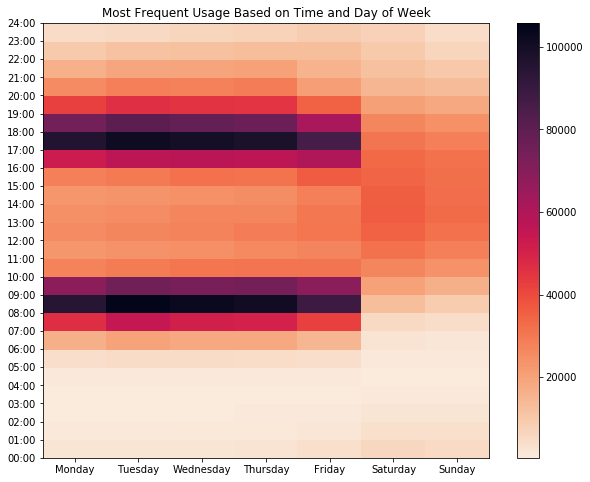

In [6]:
plt.figure(figsize=[10,8])

bins_x= np.arange(0,8,1) #X bins
bins_y = np.arange(0,25,1) #Y bins
x_pos = np.arange(0.5, 7.5, 1) #Position of x labels
x_label = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] #Create x labels
#Create y labels
y_label=[]
for i in bins_y:
    time = str(i).zfill(2) + str(':00')
    y_label.append(time)

#Main heatmap code
plt.hist2d(data=df, x='start_week_num', y='start_hour', cmap='rocket_r', cmin=0.1, bins=[bins_x,bins_y])
plt.xticks(x_pos,x_label)
plt.yticks(bins_y, y_label)
plt.colorbar()
plt.title('Most Frequent Usage Based on Time and Day of Week');

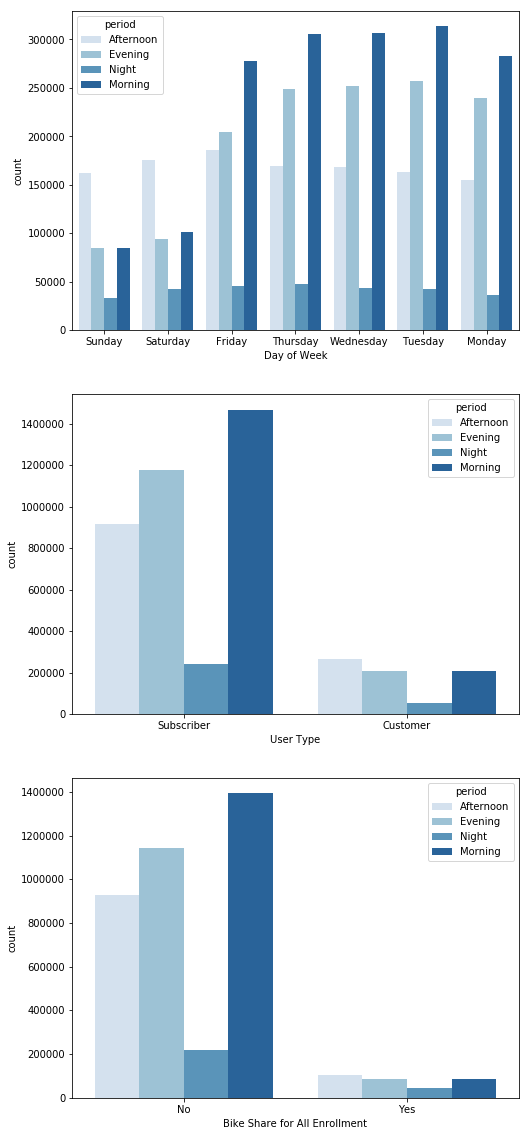

In [19]:
fig, ax = plt.subplots(3,1, figsize=[8,20])
sb.countplot(data=df, x='start_week', hue='period', palette='Blues', ax=ax[0])
sb.countplot(data=df, x='user_type', hue='period', palette='Blues', ax=ax[1], order= df.user_type.value_counts().index)
sb.countplot(data=df, x='bike_share_for_all_trip', hue='period', palette='Blues', ax=ax[2]);
ax[0].set_xlabel('Day of Week')
ax[1].set_xlabel('User Type')
ax[2].set_xlabel('Bike Share for All Enrollment');

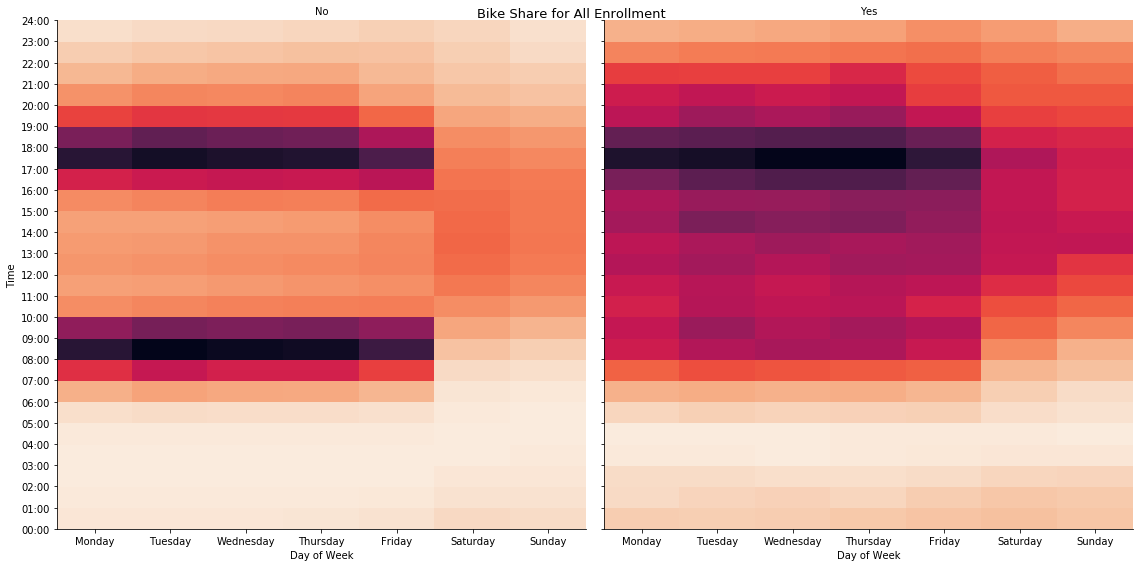

In [8]:
# Quick hack for creating heat maps with seaborn's PairGrid
def heatmap(x,y, **kwargs):
    bins_x= np.arange(0,8,1) #X bins
    bins_y = np.arange(0,25,1) #Y bins

    x_pos = np.arange(0.5, 7.5, 1) #Position of x labels

    x_label = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'] #Create x labels

    #Create y labels
    y_label=[]
    for i in bins_y:
        time = str(i).zfill(2) + str(':00')
        y_label.append(time)

    #Main heatmap code    
    plt.hist2d(data=df, x= x, y= y, cmap='rocket_r', bins=[bins_x,bins_y])
    plt.xticks(x_pos,x_label)
    plt.yticks(bins_y, y_label)

g= sb.FacetGrid(data=df, col='bike_share_for_all_trip', height=8)
g.map(heatmap, 'start_week_num','start_hour')
g.set_xlabels('Day of Week')
g.set_ylabels('Time')
g.set_titles('{col_name}')
g.fig.suptitle('Bike Share for All Enrollment', fontsize=13);

In [11]:
#Define log function
def log_trans(x, inverse=False):
    if not inverse:
        return np.log10(x)
    else:
        return np.power(10,x)

#Sampling 5000 entries so that multivariate plots are clearer and render faster    
np.random.seed(0)
samples = np.random.choice(df.shape[0], 5000, replace = False)
df_samp = df.loc[samples,:]
df_samp['log_min'] = df_samp['duration_min'].apply(log_trans)
df_samp['log_distance'] = df_samp['distance'].apply(log_trans)

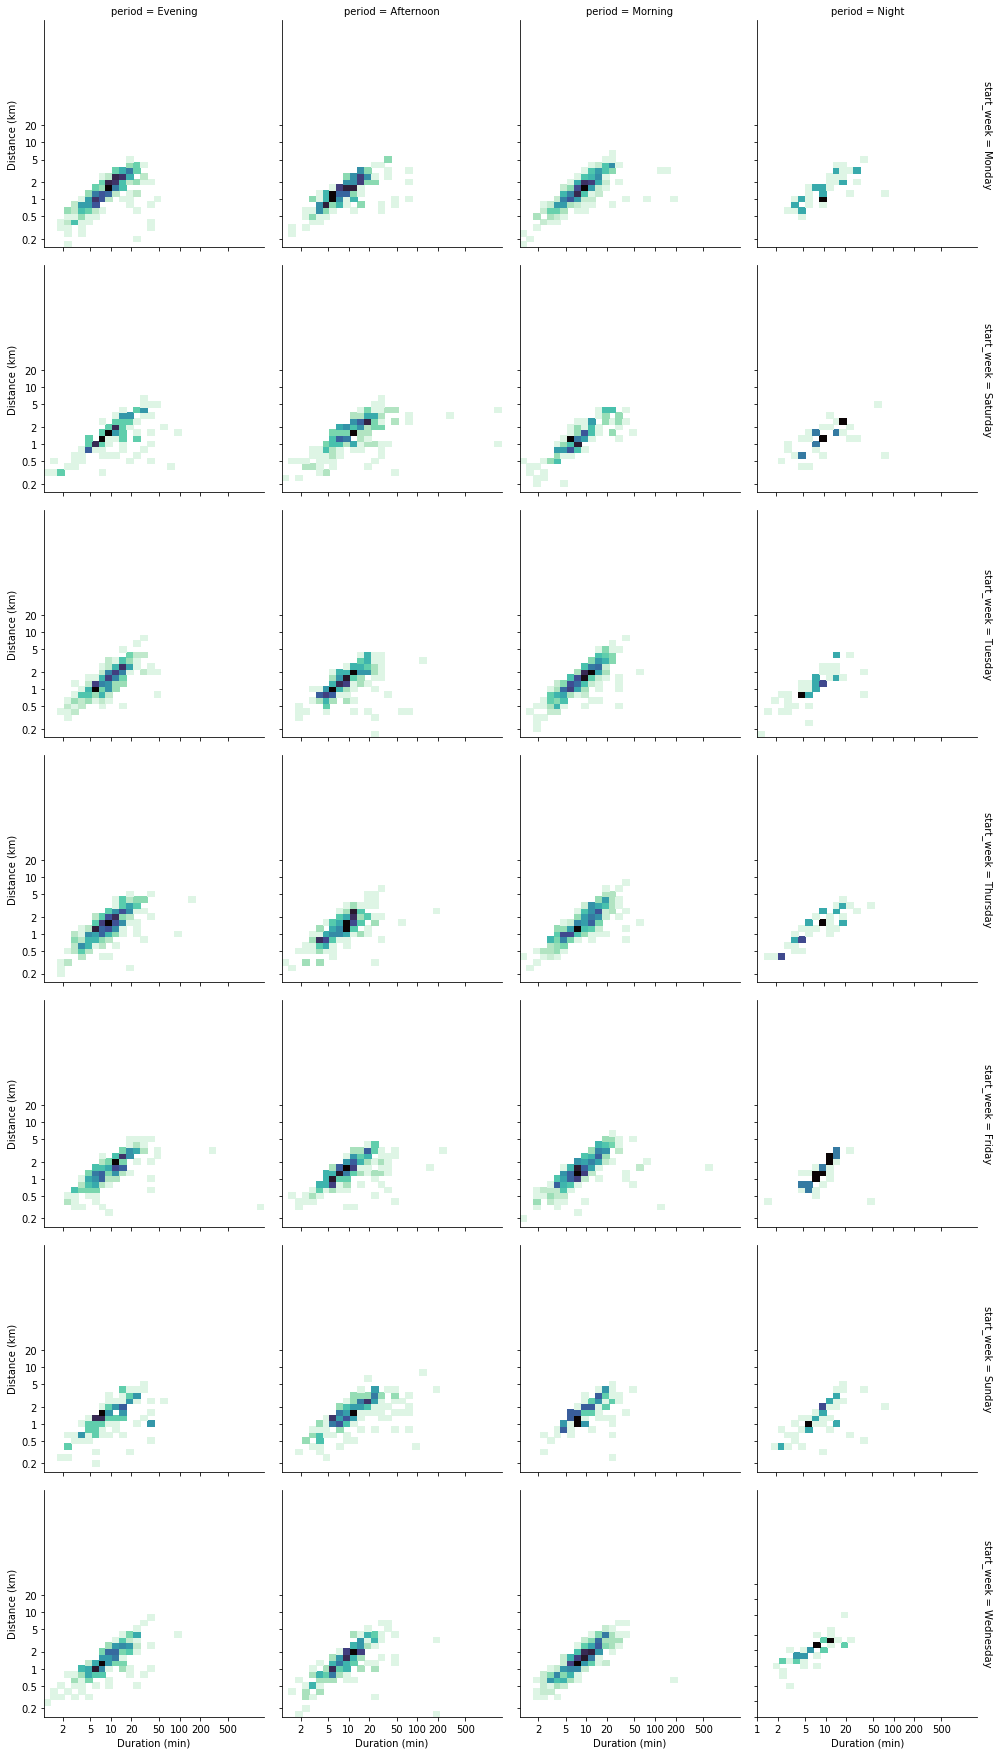

In [12]:
def heatmap2(x,y,**kwargs):
    
    bins_x=np.arange(df_samp.log_min.min(), df_samp.log_min.max()+0.1,0.1)
    bins_y=np.arange(df_samp.log_distance.min(), df_samp.log_min.max()+0.1, 0.1)
    
    tick_locs1= [1,2,5,10,20,50,100,200, 500] # values for duration
    tick_locs2= [0.05,0.1,0.2,0.5,1,2,5,10,20] # values for distance

    plt.hist2d(data=df_samp, x=x, y=y, cmap='mako_r',bins=[bins_x, bins_y], cmin=1)
    plt.xticks(log_trans(tick_locs1),tick_locs1)
    plt.yticks(log_trans(tick_locs2), tick_locs2)
    
g= sb.FacetGrid(data=df_samp, col='period', row='start_week', height=3.5, margin_titles=True)
g.map(heatmap2, 'log_min', 'log_distance')

g.set_xlabels('Duration (min)')
g.set_ylabels('Distance (km)');

In [13]:
#Pearson correlation after log transform
df_samp[['log_min','log_distance']].corr(method='pearson')

,log_min,log_distance
log_min,1.000000,0.708759
log_distance,0.708759,1.000000


In [14]:
#Spearman correlation for non-linear pair (prior to log transform)
df_samp[['duration_min','distance']].corr(method='spearman')

,duration_min,distance
duration_min,1.00000,0.78106
distance,0.78106,1.00000
